In [34]:
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
from scipy.stats.mstats import mquantiles
from scipy.stats import zscore, ttest_ind
from nitime import utils
from nitime import algorithms as alg
import pyleoclim as pyleo

In [2]:
# read the following data if not running the code above
# detrended ensembles of time series, x: time, y: d18O
# y is already detrended
with open('x_detrend.pkl', 'rb') as handle:
    x_detrend = pickle.load(handle)
with open('y_detrend.pkl', 'rb') as handle:
    y_detrend = pickle.load(handle)
#site names
holo_list=['Heshang','Sanbao','Jiuxian','Lianhua','Mawmluh','Xianglong','Dongge','Sahiya','Hoq','Dark','Shennong']
#lat and lon
with open('lat_2k.pkl', 'rb') as handle:
    lat_2k = pickle.load(handle)
with open('lon_2k.pkl', 'rb') as handle:
    lon_2k = pickle.load(handle)

In [4]:
# MC-EOF
# First upscale to 50yr resolution
# by binning, averaging with weights
# weights are estimated by the gkernel function
# points close to the binning center has higher weights


def gkernel(d,h):
    b = 1.0/np.sqrt(2*np.pi*h)*np.exp(-d**2/(2*h**2))
    return b

def upscale(age_up,age,yvalue):
    '''Upscale a time series with more coarse time resolution
    Inputs:
    age_up: The new coarse age array
    age: The original age array
    yvalue: The original time series
    Outputs:
    yvalue: The new upscaled time series'''
    
    nC = age.shape[0]
    y_up = np.zeros((nC,len(age_up)-1))
    y_up[:] = np.nan
    
    for j in range(nC):
        x = age[j,:]
        y = yvalue[j,:]

        for i in range(len(age_up)-1):
            xslice = x[(x>=age_up[i])&(x<age_up[i+1])]
            yslice = y[(x>=age_up[i])&(x<age_up[i+1])]

            if len(xslice)>0:
                d = xslice-xc[i]
                weight = gkernel(d,11)
                yc=sum(weight*yslice)/sum(weight)
            else:
                yc=np.nan
            y_up[j,i] = yc
            
    return y_up
      

In [5]:
# define the more coarse age range
holo_age10 = np.arange(-40,10000,40)
# xc is the center of each age interval
xc = holo_age10+20
yup={}

for site in holo_list:
    print(site)
    yup[site] = upscale(holo_age10, x_detrend[site], y_detrend[site])

Heshang
Sanbao
Jiuxian
Lianhua
Mawmluh
Xianglong
Dongge
Sahiya
Hoq
Dark
Shennong


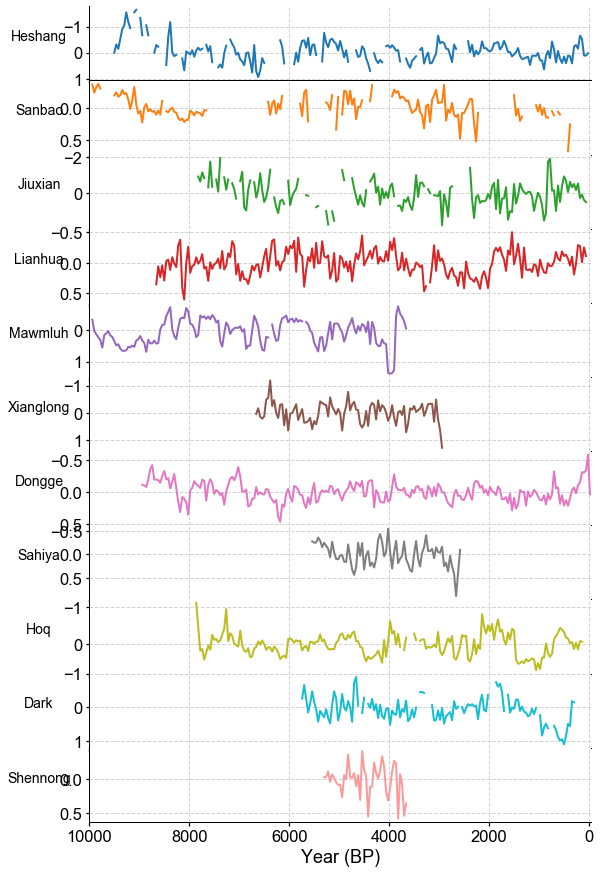

In [7]:
# Plot one ensemble of upscales time series
clrs1 = sns.color_palette("tab10")
clrs2 = sns.color_palette('Paired')

clrs=clrs1+clrs2[4:]

fig, axs = plt.subplots(11, 1, figsize=(9, 15),sharex=True)
fig.subplots_adjust(hspace=0.001)

i=0
for site in holo_list:
    axs[i].plot(xc[:-1],yup[site][0,:],color=clrs[i])
    #axs[i].plot(np.linspace(0, 10000, 1001),insol_Sanbao_std,color = Dark2_7.mpl_colors[6],linestyle='dashed')
    axs[i].set_xlabel('Year (BP)')
    if site=='Donggenew':
        axs[i].set_ylabel('Dongge',rotation=0,fontsize=14)
    else:
        axs[i].set_ylabel(site,rotation=0,fontsize=14)
    axs[i].set_xlim(-50,10000)
    #start, end = axs[i].get_ylim()
    #axs[i].yaxis.set_ticks(np.arange(start, end, 2))
    axs[i].invert_xaxis()
    axs[i].invert_yaxis()
    axs[i].yaxis.set_label_coords(-0.1, 0.5)
    i=i+1

In [8]:
# Using MSSA in Pyleoclim to fill missing values in yup
# This runs very slowly. It may take hours!
yup_fill={}
for site in holo_list:
    print(site)
    nC = x_detrend[site].shape[0]
    yup_fill[site] = np.zeros((nC,len(holo_age10)-1))
    yup_fill[site][:]=np.nan
    
    for j in range(nC):
        xup=xc[:-1][~np.isnan(yup[site][j,:])]
        yslim=yup[site][j,(xc[:-1]>=min(xup))&(xc[:-1]<=max(xup))]
        xslim=xc[:-1][(xc[:-1]>=min(xup))&(xc[:-1]<=max(xup))]
        
        ts_miss = pyleo.Series(time=np.arange(len(xslim)),value=yslim)
        ts_n    = ts_miss.standardize()
        miss_ssa = ts_n.ssa()
        
        RCk = miss_ssa['RC'][:,:21].sum(axis=1)
        rc_ts = pyleo.Series(time=xslim,value=RCk)
        rc_n    = rc_ts.standardize()
        yup_fill[site][j,(xc[:-1]>=min(xup))&(xc[:-1]<=max(xup))]=rc_n.value

Heshang
Sanbao
Jiuxian
Lianhua
Mawmluh
Xianglong
Dongge
Sahiya
Hoq
Dark
Shennong


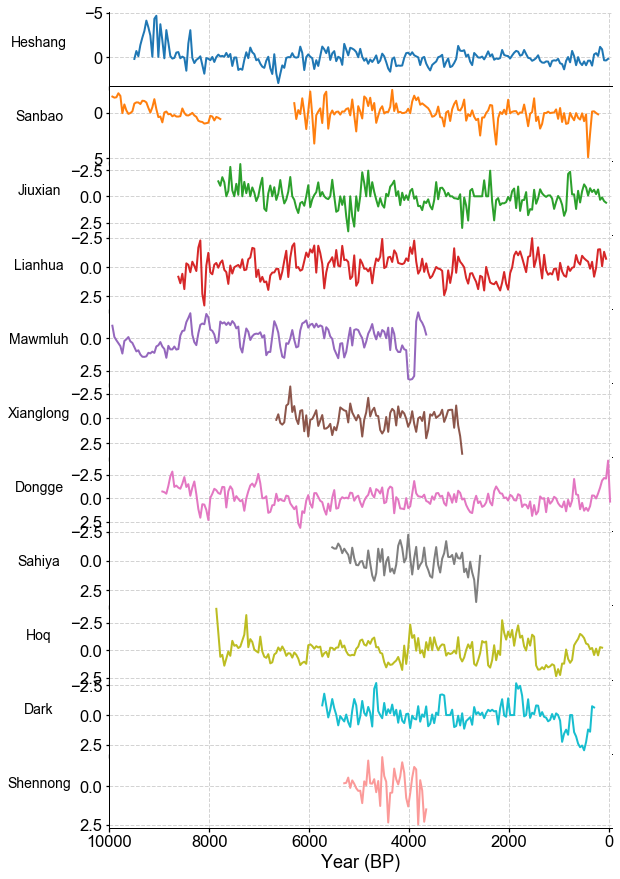

In [11]:
# One ensemble of time series will missing values filled
fig, axs = plt.subplots(11, 1, figsize=(9, 15),sharex=True)
fig.subplots_adjust(hspace=0.001)

i=0
for site in holo_list:
    axs[i].plot(xc[:-1],yup_fill[site][0,:],color=clrs[i])
    #axs[i].plot(np.linspace(0, 10000, 1001),insol_Sanbao_std,color = Dark2_7.mpl_colors[6],linestyle='dashed')
    axs[i].set_xlabel('Year (BP)')
    if site=='Donggenew':
        axs[i].set_ylabel('Dongge',rotation=0,fontsize=14)
    else:
        axs[i].set_ylabel(site,rotation=0,fontsize=14)
    axs[i].set_xlim(-50,10000)
    #start, end = axs[i].get_ylim()
    #axs[i].yaxis.set_ticks(np.arange(start, end, 2))
    axs[i].invert_xaxis()
    axs[i].invert_yaxis()
    axs[i].yaxis.set_label_coords(-0.14, 0.5)
    i=i+1

In [22]:
# convert the dictionary yup_fill to a nested numpy array
# with the dimension of records
yup_fill_list=[]
for site in holo_list:
    yup_fill_list.append(yup_fill[site])

yup_fill_array = np.array(yup_fill_list)

In [28]:
from statsmodels.multivariate.pca import PCA
import copy
import statsmodels.api as sm

def mcpca(yup_fill_array, nC):
    '''The Monte-Carlo PCA fucntion
    Input:
    yup_fill_array: a numpy array with three dimensions (nrec,nC,nt)
    The first dimension nrec is the number of records
    The second dimension nC is the number of Monte-Carlo simulations
    The third dimension is the length of time for each record
    nC: the number of Monte-Carlo simulations
    Output:
    eig_mc: eigenvalues (nC,nrec)
    eig_ar1: eigenvalues if assuming each time series follows AR1 (nC,nrec)
    pc_mc: PC series of all components (nrec,nC,nt)
    eof_mc: EOFs of all components (nrec, nC, nt)
    '''
    nrec=yup_fill_array.shape[0]
    nt=yup_fill_array.shape[2]
    ncomp=nrec
    #pc
    pc_mc = np.zeros((nrec,nC,nt))
    #eof (spatial loadings)
    eof_mc = np.zeros((nrec,nC,nrec))
    #eigenvalues
    eig_mc = np.zeros((nC,nrec))
    eig_ar1 = np.zeros((nC,nrec))

    for j in range(nC):
        compup=np.zeros((nt,nrec))
        compup_ar1=np.zeros((nt,nrec))
        compup_ar1[:]=np.nan
        for i in range(nrec):
            a=copy.deepcopy(yup_fill_array[i,j,:])

            coef,sigma=alg.AR_est_YW(a[~np.isnan(a)],1)
            ar1_mod = sm.tsa.AR(a, missing='drop').fit(maxlag=1)
            g = ar1_mod.params[0]
            ar = np.r_[1, -g]  # AR model parameter
            ma = np.r_[1, 0.0]  # MA model parameters
            sig=np.std(a[~np.isnan(a)])
            sig_n=sig*np.sqrt(1-coef**2)
            #X_ar, noise, aph = utils.ar_generator(len(a[~np.isnan(a)]), sig_n[0], coef)
            X_ar = sm.tsa.arma_generate_sample(ar=ar, ma=ma, nsample=len(a), burnin=50, sigma=sig_n)
            #compup_ar1[~np.isnan(a),i]=X_ar
            #compup_ar1[np.isnan(a),i]=np.nanmean(X_ar)
            compup_ar1[:,i]=X_ar

            a[np.isnan(a)]=np.nanmean(a)
            compup[:,i]=a

        pc = PCA(compup,ncomp=ncomp)
        pc_ar1 = PCA(compup_ar1,ncomp=ncomp)

        eig_mc[j,:] = pc.eigenvals
        eig_ar1[j,:] = pc_ar1.eigenvals

        for k in range(ncomp):
            if pc.loadings[:,k][0]>0:
                pc_mc[k,j,:]=pc.factors[:,k]
                eof_mc[k,j,:]=pc.loadings[:,k]
            else:
                pc_mc[k,j,:]=-pc.factors[:,k]
                eof_mc[k,j,:]=-pc.loadings[:,k]
                
    return eig_mc, eig_ar1, pc_mc, eof_mc

In [29]:
# Conduct MC-PCA with 1000 ensembles
eig_mc, eig_ar1, pc_mc, eof_mc = mcpca(yup_fill_array, 1000)

/Users/hujun/miniconda3/envs/pyleoclim/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: the 'sigma'' keyword is deprecated, use 'scale' instead


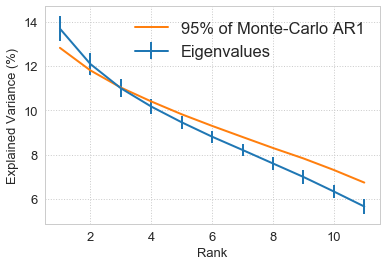

In [30]:
sns.set_style("whitegrid")
plt.errorbar(range(1,12),np.mean(eig_mc,axis=0)/sum(np.mean(eig_mc,axis=0))*100,yerr=np.std(eig_mc,axis=0)/sum(np.mean(eig_mc,axis=0))*100,label='Eigenvalues')
plt.plot(range(1,12),np.percentile(eig_ar1,90,axis=0)/sum(np.mean(eig_mc,axis=0))*100,label='95% of Monte-Carlo AR1')
plt.xlabel('Rank', fontsize=13)
plt.ylabel('Explained Variance (%)',fontsize=13)
plt.legend()
plt.grid(linestyle='dotted')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.savefig('eig_mc.pdf')

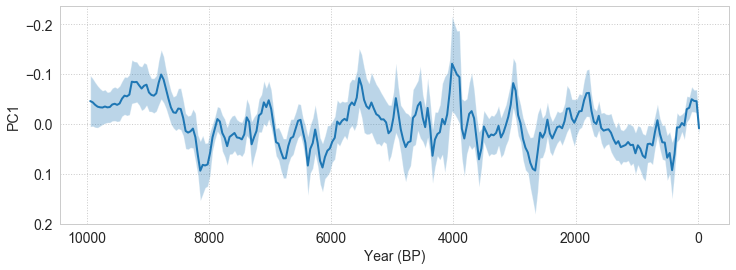

In [32]:
plt.figure(figsize=(12,4))
plt.plot(xc[:-1],np.mean(pc_mc[0,:,:],axis=0))
plt.fill_between(xc[:-1],np.mean(pc_mc[0,:,:],axis=0)-np.std(pc_mc[0,:,:],axis=0),np.mean(pc_mc[0,:,:],axis=0)+np.std(pc_mc[0,:,:],axis=0),alpha=0.3)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Year (BP)',fontsize=14)
plt.ylabel('PC1',fontsize=14)
plt.grid(linestyle='dotted')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('pca_pc1.pdf',dpi=300,bbox_inches='tight')

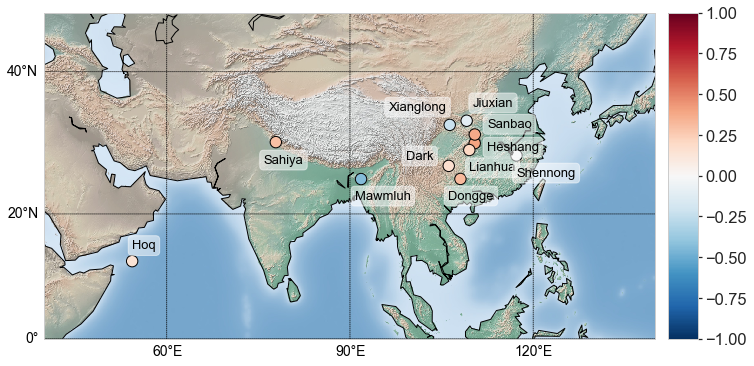

In [33]:
fig=plt.figure(figsize=(12,6))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=47,llcrnrlon=40,urcrnrlon=140,lat_ts=20,resolution='c')
m.shadedrelief(scale=0.5,zorder=0)

m.drawcoastlines()
m.drawparallels(np.arange(0.,61.,20.),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(60.,151.,30.),labels=[0,0,0,1], fontsize=14)

tx2,ty2 = m(np.array(lon_2k)-8,np.array(lat_2k)+2)
tx2[0],ty2[0]=m(np.array(lon_2k[0]+2),np.array(lat_2k[0])-1)
tx2[1],ty2[1]=m(np.array(lon_2k[1])+2,np.array(lat_2k[1])+1)
tx2[2],ty2[2]=m(np.array(lon_2k[2])+1,np.array(lat_2k[2])+2)
tx2[3],ty2[3]=m(np.array(lon_2k[3]),np.array(lat_2k[3])-3)
tx2[4],ty2[4]=m(np.array(lon_2k[4])-1,np.array(lat_2k[4])-3)
tx2[5],ty2[5]=m(np.array(lon_2k[5])-10,np.array(lat_2k[5])+2)
tx2[6],ty2[6]=m(np.array(lon_2k[6])-2,np.array(lat_2k[6])-3)
tx2[7],ty2[7]=m(np.array(lon_2k[7])-2,np.array(lat_2k[7])-3)
tx2[8],ty2[8]=m(np.array(lon_2k[8]),np.array(lat_2k[8])+2)
tx2[9],ty2[9]=m(np.array(lon_2k[9]-7),np.array(lat_2k[9])+1)
tx2[10],ty2[10]=m(np.array(lon_2k[10]),np.array(lat_2k[10])-3)

x2,y2=m(lon_2k,lat_2k)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

sc=m.scatter(x2,y2,c=np.median(eof_mc[0,:,:],axis=0),marker='o',s=130,vmin=-1.0,vmax=1.0,edgecolors='black',cmap=plt.cm.RdBu_r)
cbar = m.colorbar(sc)

for i in range(11):
    #m.plot(x2[i],y2[i],'o',markersize=12, color=Dark2_8.mpl_colors[i],markeredgecolor='white',markeredgewidth=1)
    plt.text(tx2[i],ty2[i],holo_list[i],fontsize=13,color='black',bbox=props)

fig.savefig('pca_loading1.pdf',dpi=300,bbox_inches='tight')